---
Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorflow
from tensorflow import keras as kr

---
# Función de activación custom

Para crear una función de activación custom tan solo hay que crear una función como haríamos siempre.  
Una vez definida esta función correctamente solo tendremos que introducirla en "activation", en vez de las que vienen por defecto (relu, sigmoid, etc...) a la hora de definir el modelo.


In [2]:
# Función de activación customizada que devuelve la media entre la relu y la sigmoid
def custom_activation1(input):
    return (kr.activations.relu(input) + kr.activations.sigmoid(input)) / 2

# Función de activación customizada que devuelve la diferencia entre softmax y softplus
def custom_activation2(input):
    return kr.activations.softmax(input) - kr.activations.softplus(input)

# Función de activación customizada que aplica la función relu al resultado de la función selu
def custom_activation3(input):
    return kr.activations.relu(kr.activations.selu(input))

---
#### Carga de datos

In [3]:
input_data = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
target_data = np.array([[0], [1], [1], [0]])

#### Definición del Modelo

In [4]:
model = kr.models.Sequential()
model.add(kr.layers.Dense(32, activation=custom_activation1))
model.add(kr.layers.Dense(16, activation=custom_activation3))
model.add(kr.layers.Dense(1, activation=custom_activation2))

#### Compilación del Modelo

In [5]:
model.compile   (loss='mean_squared_error',
                optimizer='adam',
                metrics=['binary_accuracy'])

#### Entrenamiento del Modelo

In [6]:
model.fit(input_data, target_data, epochs=1000)

Epoch 1/1000
1/1 [==============================] - 1s 500ms/step - loss: 0.7469 - binary_accuracy: 0.5000
Epoch 2/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6947 - binary_accuracy: 0.5000
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6446 - binary_accuracy: 0.5000
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5980 - binary_accuracy: 0.5000
Epoch 5/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5537 - binary_accuracy: 0.5000
Epoch 6/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5130 - binary_accuracy: 0.5000
Epoch 7/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4761 - binary_accuracy: 0.5000
Epoch 8/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4429 - binary_accuracy: 0.5000
Epoch 9/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4130 - binary_accuracy: 0.5000
Epoch 10/1000
1/1 [==============================] - 

#### Evaluación del Modelo

In [7]:
model.evaluate(input_data, target_data)

1/1 [==============================] - 0s 110ms/step - loss: 0.0012 - binary_accuracy: 1.0000


[0.0011841213563457131, 1.0]

#### Predicción del Modelo

In [8]:
print(model.predict(input_data).round())

[[0.]
 [1.]
 [1.]
 [0.]]


---
# Capa Conv 3D

Una capa convolucional es una capa que aplica un __filtro o varios__ sobre lo que se la ha dado, (véase filtros y máscaras del tema anterior). Una capa Conv3D hace esto pero en imágenes en 3 dimensiones (más una capa de canal).

Argumentos importantes:
* filters: el número de filtros.
* kernel_size: dimensiones del kernel ("máscara").
* activation: función de activación.

Enlaces de interés:


* [Explicación Capa Conv IBM](https://developer.ibm.com/es/articles/cc-convolutional-neural-network-vision-recognition/),  
* [Vídeos de DotCSV sobre Capas Convs](https://www.youtube.com/playlist?list=PL-Ogd76BhmcBaUXZGPJkmQpLgrBgGZ7v0),  
* [API de Keras](https://keras.io/api/layers/convolution_layers/convolution3d/),  
* [Geeks for Geeks Conv2D con todos los argumentos](https://www.geeksforgeeks.org/keras-conv2d-class/)
* [Código](https://github.com/christianversloot/machine-learning-articles/blob/main/a-simple-conv3d-example-with-keras.md)

#### Código de preparación

Configuración del modelo

In [9]:
# -- Preparatory code --
# Model configuration
batch_size = 100 # Nº de muestras propagadas en la red neuronal.
no_epochs = 30 # Nº de iteraciones
learning_rate = 0.001
no_classes = 10 # Nº de neuronas de la última capa. Ha de coincidir con el número de clases finales.
validation_split = 0.2 # % de los datos que se usarán para el test.
verbosity = 1

Convertir vector 1D en vector 3D

In [10]:
# Convert 1D vector into 3D values, provided by the 3D MNIST authors at
# https://www.kaggle.com/daavoo/3d-mnist
def array_to_color(array, cmap="Oranges"):
    s_m = plt.cm.ScalarMappable(cmap=cmap)
    return s_m.to_rgba(array)[:, :-1]

Reformar data a un formato que pueda manejar Conv3D

In [11]:
# Reshape data into format that can be handled by Conv3D layers.
# Courtesy of Sam Berglin; Zheming Lian; Jiahui Jang - University of Wisconsin-Madison
# Report - https://github.com/sberglin/Projects-and-Papers/blob/master/3D%20CNN/Report.pdf
# Code - https://github.com/sberglin/Projects-and-Papers/blob/master/3D%20CNN/network_final_version.ipynb
def rgb_data_transform(data):
    data_t = []
    for i in range(data.shape[0]):
        data_t.append(array_to_color(data[i]).reshape(16, 16, 16, 3))
    return np.asarray(data_t, dtype=np.float32)

#### Código de procesamiento

Carga de datos

In [12]:
hf = h5py.File("02_Data/full_dataset_vectors.h5", "r")

Preparación de datos

In [13]:
# Split the data into training/test features/targets
X_train = hf["X_train"][:]
Y_train = hf["y_train"][:]
X_test = hf["X_test"][:]
Y_test = hf["y_test"][:]

# Determine sample shape
sample_shape = (16, 16, 16, 3)

# Reshape data into 3D format
X_train = rgb_data_transform(X_train)
X_test = rgb_data_transform(X_test)

# Convert target vectors to categorical targets
Y_train = kr.utils.to_categorical(Y_train).astype(np.int32)
Y_test = kr.utils.to_categorical(Y_test).astype(np.int32)

#### Creación del Modelo

In [14]:
# Create the model
model = kr.models.Sequential()
model.add(kr.layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(kr.layers.MaxPooling3D(pool_size=(2, 2, 2)))
model.add(kr.layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(kr.layers.MaxPooling3D(pool_size=(2, 2, 2)))
model.add(kr.layers.Flatten())
model.add(kr.layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(kr.layers.Dense(no_classes, activation='softmax'))

#### Compilación del Modelo

In [15]:
# Compile the model
model.compile   (loss=tensorflow.keras.losses.categorical_crossentropy,
                optimizer=tensorflow.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])

#### Entrenamiento del Modelo

In [16]:
# Fit data to model
history = model.fit (X_train, Y_train,
                    batch_size=batch_size,
                    epochs=no_epochs,
                    verbose=verbosity,
                    validation_split=validation_split)

Epoch 1/30
80/80 [==============================] - 69s 853ms/step - loss: 2.2091 - accuracy: 0.2265 - val_loss: 1.8638 - val_accuracy: 0.3720
Epoch 2/30
80/80 [==============================] - 69s 865ms/step - loss: 1.7154 - accuracy: 0.4227 - val_loss: 1.6595 - val_accuracy: 0.4370
Epoch 3/30
80/80 [==============================] - 68s 855ms/step - loss: 1.4782 - accuracy: 0.5033 - val_loss: 1.3923 - val_accuracy: 0.5270
Epoch 4/30
80/80 [==============================] - 70s 877ms/step - loss: 1.3380 - accuracy: 0.5451 - val_loss: 1.3235 - val_accuracy: 0.5575
Epoch 5/30
80/80 [==============================] - 70s 875ms/step - loss: 1.2488 - accuracy: 0.5726 - val_loss: 1.2326 - val_accuracy: 0.5890
Epoch 6/30
80/80 [==============================] - 70s 873ms/step - loss: 1.1826 - accuracy: 0.5914 - val_loss: 1.1850 - val_accuracy: 0.5840
Epoch 7/30
80/80 [==============================] - 70s 870ms/step - loss: 1.1271 - accuracy: 0.6097 - val_loss: 1.1594 - val_accuracy: 0.5915

#### Evaluación del Modelo

In [17]:
# Generate generalization metrics
score = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.0351588726043701 / Test accuracy: 0.6744999885559082


#### Visualización

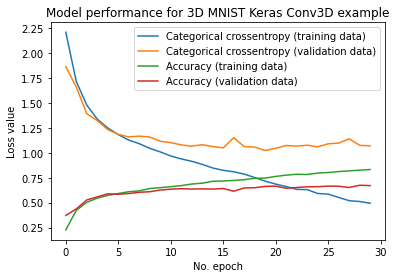

In [18]:
# Plot history: Categorical crossentropy & Accuracy
plt.plot(history.history['loss'],
        label='Categorical crossentropy (training data)')
plt.plot(history.history['val_loss'],
        label='Categorical crossentropy (validation data)')
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'],
        label='Accuracy (validation data)')
plt.title('Model performance for 3D MNIST Keras Conv3D example')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()